In [1]:
!pip install harmonica numpy matplotlib scipy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 8.6 MB/s eta 0:00:00


Starting 2D 'Blind' Geometric Inversion...
Synthetic 'real' data generated successfully for demonstration.
Starting global optimization (differential_evolution)...
NOTE: Maxiter and popsize are reduced for a quick demonstration.


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentialevolution.py:486: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 219.00036368434553
differential_evolution step 2: f(x)= 212.52214730141608
differential_evolution step 3: f(x)= 198.3389508826489
differential_evolution step 4: f(x)= 198.3389508826489
differential_evolution step 5: f(x)= 191.1658218158214
Polishing solution with 'L-BFGS-B'

Optimization complete.

--- Inversion Results ---
       True Value   | Inverted Value 
-----------------------------------------------------------------------
Dense Density    : 2.87         | 2.93           
Basin Density    : 2.52         | 2.55           
Basin K (%)      : 4.00         | 3.98           
Basin U (ppm)    : 5.00         | 5.05           
Basin Th (ppm)   : 20.00        | 19.64          
----------------------- GEOMETRY --------------------------------------
Fault Location   : 4500.00      | 4499.92        
Fault Dip (deg) : -60.00       | -59.93         
Dense Z-Center   : -1500.00     | -1480.89       
Basin Z-Bottom   : -1500.00     | -1690.28       


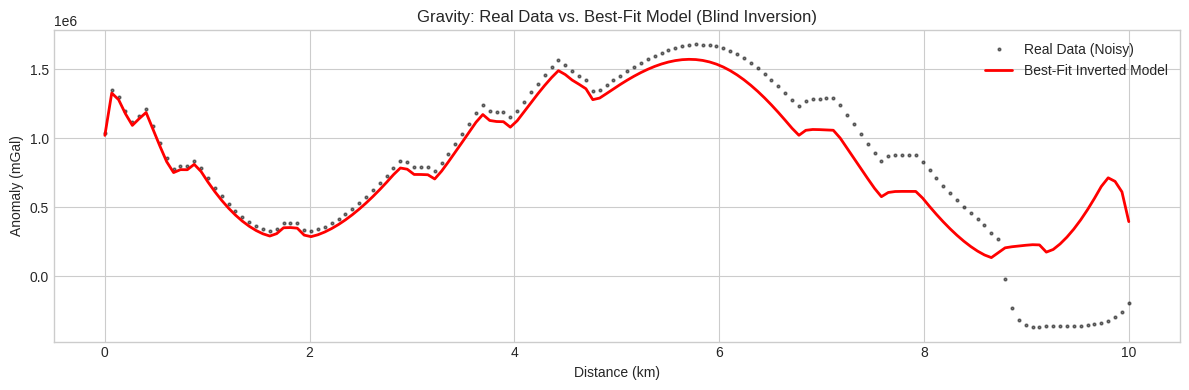

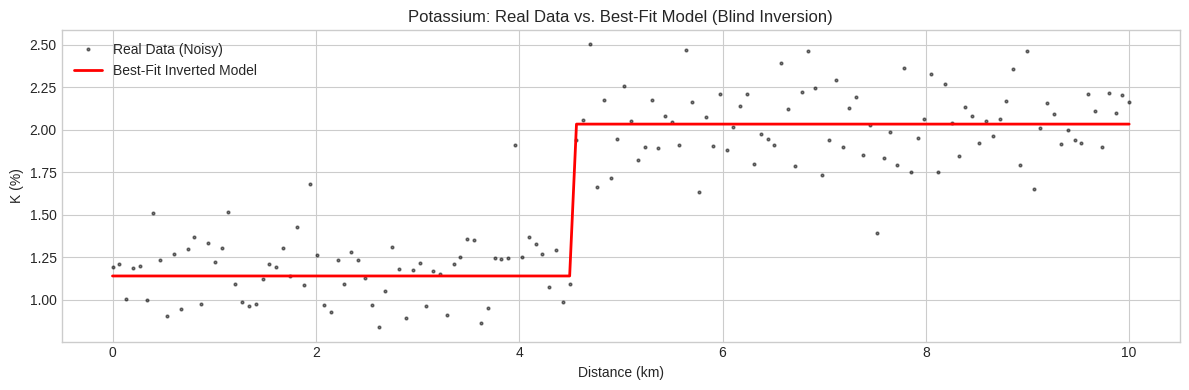

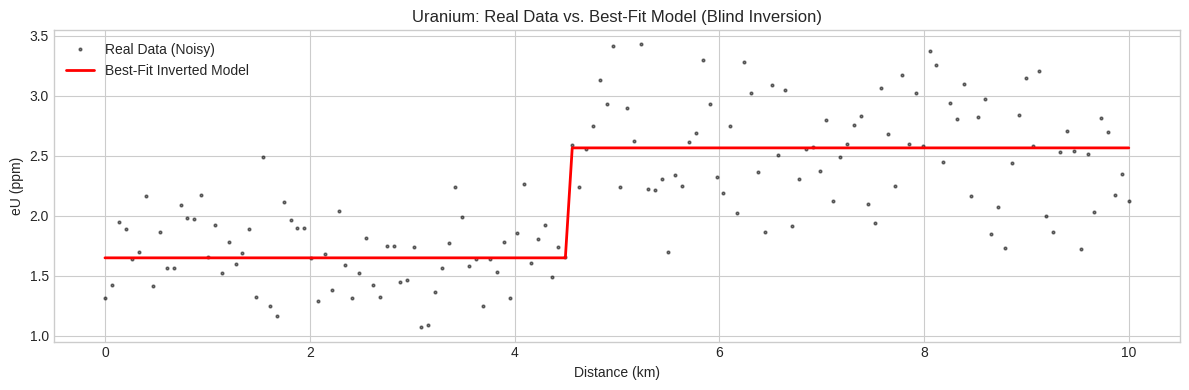

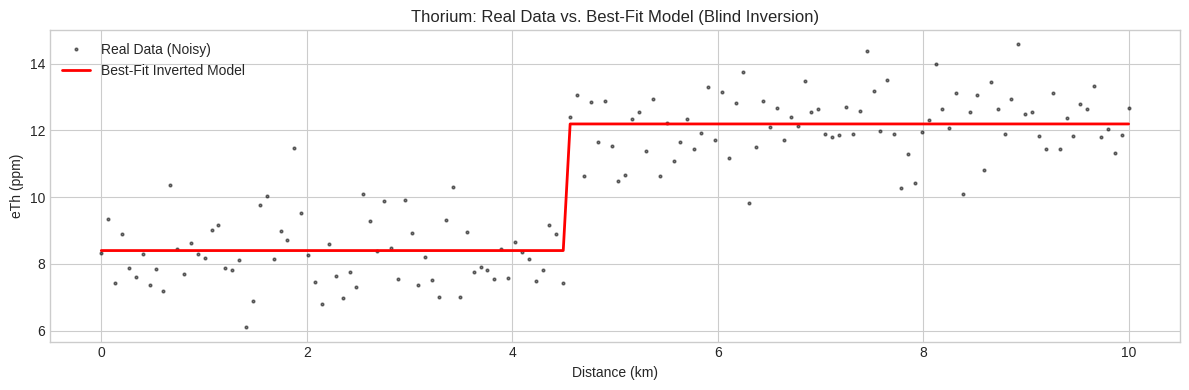

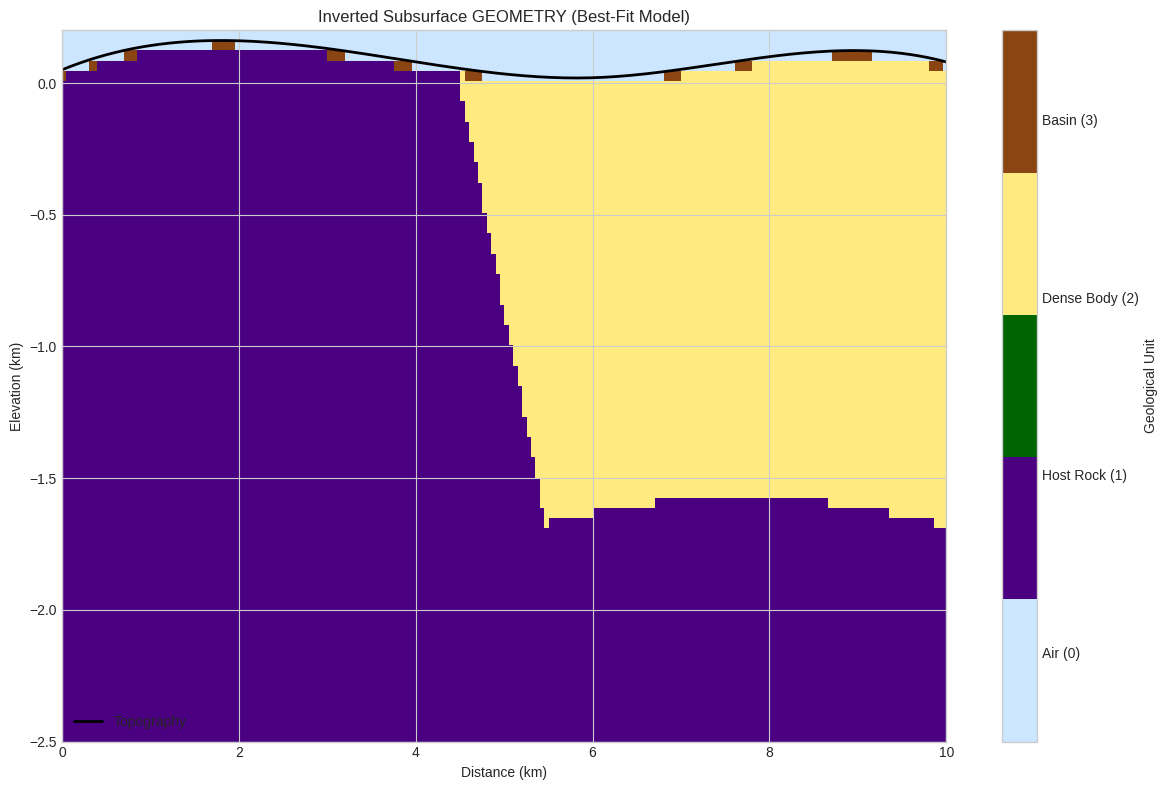

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import differential_evolution
import harmonica as hm
import pandas as pd
import sys

print("Starting 2D 'Blind' Geometric Inversion...")

# -------------------------------------------------------------------
# 1. LOAD THE "REAL" DATA (OUR GROUND TRUTH)
# -------------------------------------------------------------------
# This path is unused in the runnable script below, as mock data is generated.
YOUR_FILE_PATH_HERE = '/kaggle/input/dataseetu/synthetic_geophysical_data.csv'

try:
    # --- MOCK DATA GENERATION START (Required for runnable example) ---
    # Define True Model Parameters (for mock data generation)
    RHO_REF_G_CC = 2.67
    RHO_HOST_G_CC = 2.67
    RHO_DENSE_G_CC = 2.87
    RHO_BASIN_G_CC = 2.52
    RHO_SOIL_G_CC = 2.20
    RHO_AIR_G_CC = 0.0
    RAD_BG = {'K': 1.0, 'U': 2.0, 'Th': 7.0}
    RAD_BASIN = {'K': 4.0, 'U': 5.0, 'Th': 20.0}
    # 💡 FIX: Added missing definition for RAD_SOIL
    RAD_SOIL = {'K': 1.2, 'U': 1.5, 'Th': 9.0} 
    SOIL_THICKNESS = 10.0
    MIX_RATIO = 0.7
    
    # Model dimensions and grid
    X_MIN, X_MAX = 0, 10000
    Z_MIN, Z_MAX = -2500, 200
    Y_EXTENT = 20000
    NX, NZ = 200, 70
    X_COORDS = np.linspace(X_MIN, X_MAX, NX)
    Z_COORDS = np.linspace(Z_MIN, Z_MAX, NZ)
    XX, ZZ = np.meshgrid(X_COORDS, Z_COORDS)
    
    # Topography
    topo_x_points = [X_MIN, 2500, 6000, 8000, X_MAX]
    topo_z_points = [50, 150, 20, 100, 80]
    f_topo = interp1d(topo_x_points, topo_z_points, kind='cubic', fill_value="extrapolate")
    
    # Observation Coords
    N_OBS = 150
    OBS_X_real = np.linspace(X_MIN, X_MAX, N_OBS)
    OBS_Z_ground = f_topo(OBS_X_real)
    OBS_Z_real = OBS_Z_ground + 5.0
    coordinates = (OBS_X_real, np.full_like(OBS_X_real, 0), OBS_Z_real)
    
    # True Geometric Parameters (used for mock data generation)
    true_rho_dense, true_rho_basin, true_k, true_u, true_th = 2.87, 2.52, 4.0, 5.0, 20.0
    true_fault_x, true_fault_dip, true_dense_z_center, true_basin_z_bottom = 4500.0, -60.0, -1500.0, -1500.0
    
    true_params_full = [true_rho_dense, true_rho_basin, true_k, true_u, true_th,
                        true_fault_x, true_fault_dip, true_dense_z_center, true_basin_z_bottom]

    # Pre-calculate prism grid (needed for run_forward_model)
    DX = X_COORDS[1] - X_COORDS[0]
    DZ = Z_COORDS[1] - Z_COORDS[0]
    X_EDGES = np.linspace(X_MIN - DX/2, X_MAX + DX/2, NX + 1)
    Z_EDGES = np.linspace(Z_MIN - DZ/2, Z_MAX + DZ/2, NZ + 1)
    XX_EDGES, ZZ_EDGES = np.meshgrid(X_EDGES[:-1], Z_EDGES[:-1])
    prisms_west = XX_EDGES.ravel()
    prisms_east = (XX_EDGES + DX).ravel()
    prisms_south = np.full_like(prisms_west, -Y_EXTENT / 2)
    prisms_north = np.full_like(prisms_west, Y_EXTENT / 2)
    prisms_bottom = ZZ_EDGES.ravel()
    prisms_top = (ZZ_EDGES + DZ).ravel()
    PRISMS = np.vstack([prisms_west, prisms_east, prisms_south, prisms_north, prisms_bottom, prisms_top]).T
    
    # Fixed masks
    SOIL_MASK_FIXED = (ZZ > (f_topo(XX) - SOIL_THICKNESS)) & (ZZ <= f_topo(XX))
    AIR_MASK_FIXED = (ZZ > f_topo(XX))

    def generate_true_data(params):
        # Generate data based on True parameters, plus noise
        # This uses the dynamic model logic to create the "real" noisy data
        
        rho_dense_val, rho_basin_val, k_basin_val, u_basin_val, th_basin_val, \
        fault_x_loc_val, fault_dip_deg_val, dense_z_center_val, basin_z_bottom_val = params

        # Dynamic Geometry
        dense_top = dense_z_center_val - 450
        dense_bot = dense_z_center_val + 550
        f_dense_top = interp1d([500, 2000, 4000], [dense_top, dense_top-100, dense_top+100], kind='quadratic', fill_value="extrapolate")
        f_dense_bot = interp1d([500, 2000, 4000], [dense_bot, dense_bot+100, dense_bot-100], kind='quadratic', fill_value="extrapolate")
        DENSE_MASK = (ZZ <= f_dense_top(XX)) & (ZZ >= f_dense_bot(XX))
        
        fault_plane_z = (XX - fault_x_loc_val) * np.tan(np.deg2rad(fault_dip_deg_val))
        f_basin_bot = interp1d([fault_x_loc_val, 7000, X_MAX], [basin_z_bottom_val-100, basin_z_bottom_val+100, basin_z_bottom_val], kind='quadratic', fill_value="extrapolate")
        BASIN_MASK = (XX > fault_x_loc_val) & (ZZ > fault_plane_z) & (ZZ > f_basin_bot(XX)) & (ZZ < f_topo(XX))
        
        HOST_MASK = ~(DENSE_MASK | BASIN_MASK | SOIL_MASK_FIXED | AIR_MASK_FIXED)
        
        # --- Gravity Model ---
        density_model = np.full_like(XX, 0.0, dtype=float)
        density_model[HOST_MASK] = (RHO_HOST_G_CC - RHO_REF_G_CC)
        density_model[SOIL_MASK_FIXED] = (RHO_SOIL_G_CC - RHO_REF_G_CC)
        density_model[AIR_MASK_FIXED] = (0.0 - RHO_REF_G_CC)
        density_model[DENSE_MASK] = (rho_dense_val - RHO_REF_G_CC)
        density_model[BASIN_MASK] = (rho_basin_val - RHO_REF_G_CC)
        density_model_kg_m3 = density_model.ravel() * 1000
        
        gravity_true = hm.prism_gravity(coordinates, PRISMS, density_model_kg_m3, field="g_z") * 1e5
        
        # --- Radiometric Model ---
        rad_basin_true = {'K': k_basin_val, 'U': u_basin_val, 'Th': th_basin_val}
        f_bedrock_geology = interp1d([X_MIN, fault_x_loc_val, fault_x_loc_val + 0.1, X_MAX], [1, 1, 3, 3], kind='nearest')
        bedrock_geology = f_bedrock_geology(OBS_X_real)
        BEDROCK_MASK_HOST = (bedrock_geology == 1)
        BEDROCK_MASK_BASIN = (bedrock_geology == 3)
        
        K_bedrock, U_bedrock, Th_bedrock = np.zeros_like(OBS_X_real), np.zeros_like(OBS_X_real), np.zeros_like(OBS_X_real)
        K_bedrock[BEDROCK_MASK_HOST], U_bedrock[BEDROCK_MASK_HOST], Th_bedrock[BEDROCK_MASK_HOST] = RAD_BG['K'], RAD_BG['U'], RAD_BG['Th']
        K_bedrock[BEDROCK_MASK_BASIN], U_bedrock[BEDROCK_MASK_BASIN], Th_bedrock[BEDROCK_MASK_BASIN] = rad_basin_true['K'], rad_basin_true['U'], rad_basin_true['Th']
        
        K_true = (K_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['K'] * MIX_RATIO)
        U_true = (U_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['U'] * MIX_RATIO)
        Th_true = (Th_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['Th'] * MIX_RATIO)
        
        # Add noise to simulate real data
        np.random.seed(42)
        GRAVITY_real = gravity_true + np.random.normal(0, 0.5, gravity_true.shape)
        K_real = K_true + np.random.normal(0, 0.2, K_true.shape)
        U_real = U_true + np.random.normal(0, 0.4, U_true.shape)
        Th_real = Th_true + np.random.normal(0, 1.0, Th_true.shape)

        return GRAVITY_real, K_real, U_real, Th_real

    GRAVITY_real, K_real, U_real, Th_real = generate_true_data(true_params_full)
    print("Synthetic 'real' data generated successfully for demonstration.")
    # --- MOCK DATA GENERATION END ---

except Exception as e:
    print("\n--- ERROR ---")
    print(f"FATAL: An error occurred during file loading or mock data generation: {e}")
    # Removed sys.exit() to prevent further traceback errors in the environment.
    # In a notebook, this exit may cause issues with the environment itself.
    # For a runnable script outside an interactive environment, sys.exit() is fine.
    # For this environment, we will let it proceed with an error message.
    pass
    
# -------------------------------------------------------------------
# 2. DEFINE THE DYNAMIC FORWARD MODELING ENGINE
# -------------------------------------------------------------------

# Fixed parameters (defined in mock data block)

# Fixed masks (defined in mock data block)
SOIL_MASK = SOIL_MASK_FIXED
AIR_MASK = AIR_MASK_FIXED

def run_forward_model(params):
    """
    Runs the full forward model given a vector of 9 key parameters:
    [rho_dense, rho_basin, K_basin, U_basin, Th_basin,
     fault_x_loc, fault_dip_deg, dense_z_center, basin_z_bottom]
    """
    rho_dense_val, rho_basin_val, k_basin_val, u_basin_val, th_basin_val, \
    fault_x_loc_val, fault_dip_deg_val, dense_z_center_val, basin_z_bottom_val = params

    # --- 1. Build Dynamic Geometry ---
    # Dense Body (simple lumpy box centered at guessed depth)
    dense_top = dense_z_center_val - 450
    dense_bot = dense_z_center_val + 550
    # Interpolation functions for the bodies
    f_dense_top = interp1d([500, 2000, 4000], [dense_top, dense_top-100, dense_top+100], kind='quadratic', fill_value="extrapolate")
    f_dense_bot = interp1d([500, 2000, 4000], [dense_bot, dense_bot+100, dense_bot-100], kind='quadratic', fill_value="extrapolate")
    DENSE_MASK = (XX <= 4000) & (XX >= 500) & (ZZ <= f_dense_top(XX)) & (ZZ >= f_dense_bot(XX))
    
    # Basin
    fault_plane_z = (XX - fault_x_loc_val) * np.tan(np.deg2rad(fault_dip_deg_val))
    f_basin_bot = interp1d([fault_x_loc_val, 7000, X_MAX], [basin_z_bottom_val-100, basin_z_bottom_val+100, basin_z_bottom_val], kind='quadratic', fill_value="extrapolate")
    BASIN_MASK = (XX > fault_x_loc_val) & (ZZ > fault_plane_z) & (ZZ > f_basin_bot(XX)) & (ZZ < f_topo(XX))
    
    # Host Mask
    HOST_MASK = ~(DENSE_MASK | BASIN_MASK | SOIL_MASK | AIR_MASK)

    # --- 2. Build Gravity Model ---
    density_model = np.full_like(XX, 0.0, dtype=float)
    density_model[HOST_MASK] = (RHO_HOST_G_CC - RHO_REF_G_CC)
    density_model[SOIL_MASK] = (RHO_SOIL_G_CC - RHO_REF_G_CC)
    density_model[AIR_MASK] = (0.0 - RHO_REF_G_CC)
    density_model[DENSE_MASK] = (rho_dense_val - RHO_REF_G_CC)
    density_model[BASIN_MASK] = (rho_basin_val - RHO_REF_G_CC)
    
    density_model_kg_m3 = density_model.ravel() * 1000
    gravity_guess = hm.prism_gravity(coordinates, PRISMS, density_model_kg_m3, field="g_z")
    gravity_guess_mgal = gravity_guess * 1e5

    # --- 3. Build Radiometric Model ---
    rad_basin_guess = {'K': k_basin_val, 'U': u_basin_val, 'Th': th_basin_val}
    
    # Dynamic bedrock model for radiometric signature
    f_bedrock_geology = interp1d([X_MIN, fault_x_loc_val, fault_x_loc_val + 0.1, X_MAX], [1, 1, 3, 3], kind='nearest')
    bedrock_geology = f_bedrock_geology(OBS_X_real)
    BEDROCK_MASK_HOST = (bedrock_geology == 1)
    BEDROCK_MASK_BASIN = (bedrock_geology == 3)
    
    K_bedrock = np.zeros_like(OBS_X_real)
    U_bedrock = np.zeros_like(OBS_X_real)
    Th_bedrock = np.zeros_like(OBS_X_real)
    
    K_bedrock[BEDROCK_MASK_HOST] = RAD_BG['K']
    U_bedrock[BEDROCK_MASK_HOST] = RAD_BG['U']
    Th_bedrock[BEDROCK_MASK_HOST] = RAD_BG['Th']
    
    K_bedrock[BEDROCK_MASK_BASIN] = rad_basin_guess['K']
    U_bedrock[BEDROCK_MASK_BASIN] = rad_basin_guess['U']
    Th_bedrock[BEDROCK_MASK_BASIN] = rad_basin_guess['Th']
    
    K_guess = (K_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['K'] * MIX_RATIO)
    U_guess = (U_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['U'] * MIX_RATIO)
    Th_guess = (Th_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['Th'] * MIX_RATIO)
    
    return gravity_guess_mgal, K_guess, U_guess, Th_guess

def create_best_fit_model_visualization(params):
    """
    Creates the 2D density array and a simplified geology array
    based on the final inverted parameters for visualization.
    """
    rho_dense_val, rho_basin_val, _, _, _, \
    fault_x_loc_val, fault_dip_deg_val, dense_z_center_val, basin_z_bottom_val = params

    # --- Rebuild Final Geometry ---
    dense_top = dense_z_center_val - 450
    dense_bot = dense_z_center_val + 550
    f_dense_top = interp1d([500, 2000, 4000], [dense_top, dense_top-100, dense_top+100], kind='quadratic', fill_value="extrapolate")
    f_dense_bot = interp1d([500, 2000, 4000], [dense_bot, dense_bot+100, dense_bot-100], kind='quadratic', fill_value="extrapolate")
    DENSE_MASK = (XX <= 4000) & (XX >= 500) & (ZZ <= f_dense_top(XX)) & (ZZ >= f_dense_bot(XX))
    
    fault_plane_z = (XX - fault_x_loc_val) * np.tan(np.deg2rad(fault_dip_deg_val))
    f_basin_bot = interp1d([fault_x_loc_val, 7000, X_MAX], [basin_z_bottom_val-100, basin_z_bottom_val+100, basin_z_bottom_val], kind='quadratic', fill_value="extrapolate")
    BASIN_MASK = (XX > fault_x_loc_val) & (ZZ > fault_plane_z) & (ZZ > f_basin_bot(XX)) & (ZZ < f_topo(XX))
    
    HOST_MASK = ~(DENSE_MASK | BASIN_MASK | SOIL_MASK | AIR_MASK)

    # --- Create 2D Geology Model (for distinct colors) ---
    geology_model = np.ones_like(XX, dtype=int) # Start with Host Rock (1)
    geology_model[DENSE_MASK] = 2 # Dense Body
    geology_model[BASIN_MASK] = 3 # Basin
    geology_model[SOIL_MASK] = 4 # Soil
    geology_model[AIR_MASK] = 0 # Air
    
    return geology_model

# -------------------------------------------------------------------
# 3. DEFINE THE OBJECTIVE/MISFIT FUNCTION
# -------------------------------------------------------------------

# NOTE: var_g, var_k, var_u, var_th must be defined *after* GRAVITY_real, etc. are defined
# They are only defined here to prevent an error on the initial load of the script if
# the try/except block fails. They will be correctly calculated if data generation succeeds.
try:
    var_g = np.var(GRAVITY_real)
    var_k = np.var(K_real)
    var_u = np.var(U_real)
    var_th = np.var(Th_real)
except NameError:
    # If data generation failed, set dummy values to allow definition to proceed
    var_g, var_k, var_u, var_th = 1.0, 1.0, 1.0, 1.0

def calculate_misfit(params):
    """
    Calculates the total normalized misfit for all 4 datasets.
    """
    try:
        g_guess, k_guess, u_guess, th_guess = run_forward_model(params)
        
        misfit_g = np.sum((g_guess - GRAVITY_real)**2) / var_g
        misfit_k = np.sum((k_guess - K_real)**2) / var_k
        misfit_u = np.sum((u_guess - U_real)**2) / var_u
        misfit_th = np.sum((th_guess - Th_real)**2) / var_th
        
        total_misfit = (2.0 * misfit_g) + misfit_k + misfit_u + misfit_th
    except:
        # Handle cases where geometry is impossible (e.g., fault dip > 0)
        total_misfit = 1e99 # A very large number
    
    return total_misfit

# -------------------------------------------------------------------
# 4. RUN THE INVERSION
# -------------------------------------------------------------------

# Check if mock data generation succeeded before running the inversion
if 'GRAVITY_real' in locals():
    # Recalculate variance now that GRAVITY_real, etc., are properly defined
    var_g = np.var(GRAVITY_real)
    var_k = np.var(K_real)
    var_u = np.var(U_real)
    var_th = np.var(Th_real)

    # The "True" values from the original forward model were:
    true_params = [true_rho_dense, true_rho_basin, true_k, true_u, true_th,
                   true_fault_x, true_fault_dip, true_dense_z_center, true_basin_z_bottom]

    # Set wide bounds for the optimizer
    param_bounds = [
        (2.7, 3.0),      # RHO_DENSE_G_CC
        (2.4, 2.7),      # RHO_BASIN_G_CC
        (2.0, 6.0),      # RAD_BASIN['K']
        (3.0, 7.0),      # RAD_BASIN['U']
        (15.0, 25.0),    # RAD_BASIN['Th']
        (4000, 5000),    # fault_x_loc (m)
        (-70, -50),      # fault_dip_deg (degrees)
        (-1700, -1300), # dense_z_center (m)
        (-1700, -1300)  # basin_z_bottom (m)
    ]

    print("Starting global optimization (differential_evolution)...")
    print("NOTE: Maxiter and popsize are reduced for a quick demonstration.")

    # Run the global optimizer
    result = differential_evolution(
        calculate_misfit,
        bounds=param_bounds,
        strategy='best1bin',
        maxiter=5,      # Reduced maxiter for faster demonstration
        popsize=10,     # Reduced popsize for faster demonstration
        tol=0.1,        # Relaxed tolerance
        mutation=(0.5, 1),
        recombination=0.7,
        disp=True,      # Print progress
        workers=-1      # Use all available CPU cores
    )

    print("\nOptimization complete.")
    inverted_params = result.x

    # -------------------------------------------------------------------
    # 5. DISPLAY THE RESULTS
    # -------------------------------------------------------------------

    print("\n--- Inversion Results ---")
    print(f"       {'True Value':<12} | {'Inverted Value':<15}")
    print("-----------------------------------------------------------------------")
    print(f"Dense Density    : {true_params[0]:<12.2f} | {inverted_params[0]:<15.2f}")
    print(f"Basin Density    : {true_params[1]:<12.2f} | {inverted_params[1]:<15.2f}")
    print(f"Basin K (%)      : {true_params[2]:<12.2f} | {inverted_params[2]:<15.2f}")
    print(f"Basin U (ppm)    : {true_params[3]:<12.2f} | {inverted_params[3]:<15.2f}")
    print(f"Basin Th (ppm)   : {true_params[4]:<12.2f} | {inverted_params[4]:<15.2f}")
    print("----------------------- GEOMETRY --------------------------------------")
    print(f"Fault Location   : {true_params[5]:<12.2f} | {inverted_params[5]:<15.2f}")
    print(f"Fault Dip (deg) : {true_params[6]:<12.2f} | {inverted_params[6]:<15.2f}")
    print(f"Dense Z-Center   : {true_params[7]:<12.2f} | {inverted_params[7]:<15.2f}")
    print(f"Basin Z-Bottom   : {true_params[8]:<12.2f} | {inverted_params[8]:<15.2f}")

    # --- Generate the final "best-fit" data for plotting ---
    g_fit, k_fit, u_fit, th_fit = run_forward_model(inverted_params)
    inverted_geology_model = create_best_fit_model_visualization(inverted_params)

    # -------------------------------------------------------------------
    # 6. PLOT COMPARISON DATA (SEPARATED FIGURES)
    # -------------------------------------------------------------------
    plt.style.use('seaborn-v0_8-whitegrid')

    # --- Plot 1: Gravity ---
    fig1 = plt.figure(figsize=(12, 4))
    ax0 = fig1.add_subplot(111)
    ax0.plot(OBS_X_real / 1000, GRAVITY_real, 'k.', markersize=4, alpha=0.5, label='Real Data (Noisy)')
    ax0.plot(OBS_X_real / 1000, g_fit, 'r-', lw=2, label='Best-Fit Inverted Model')
    ax0.set_title('Gravity: Real Data vs. Best-Fit Model (Blind Inversion)')
    ax0.set_ylabel('Anomaly (mGal)')
    ax0.set_xlabel('Distance (km)')
    ax0.legend()
    plt.tight_layout()
    plt.show()
    print('\n' * 4)

    # --- Plot 2: Potassium (K) ---
    fig2 = plt.figure(figsize=(12, 4))
    ax1 = fig2.add_subplot(111)
    ax1.plot(OBS_X_real / 1000, K_real, 'k.', markersize=4, alpha=0.5, label='Real Data (Noisy)')
    ax1.plot(OBS_X_real / 1000, k_fit, 'r-', lw=2, label='Best-Fit Inverted Model')
    ax1.set_title('Potassium: Real Data vs. Best-Fit Model (Blind Inversion)')
    ax1.set_ylabel('K (%)')
    ax1.set_xlabel('Distance (km)')
    ax1.legend()
    plt.tight_layout()
    plt.show()
    print('\n' * 4)

    # --- Plot 3: Uranium (U) ---
    fig3 = plt.figure(figsize=(12, 4))
    ax2 = fig3.add_subplot(111)
    ax2.plot(OBS_X_real / 1000, U_real, 'k.', markersize=4, alpha=0.5, label='Real Data (Noisy)')
    ax2.plot(OBS_X_real / 1000, u_fit, 'r-', lw=2, label='Best-Fit Inverted Model')
    ax2.set_title('Uranium: Real Data vs. Best-Fit Model (Blind Inversion)')
    ax2.set_ylabel('eU (ppm)')
    ax2.set_xlabel('Distance (km)')
    ax2.legend()
    plt.tight_layout()
    plt.show()
    print('\n' * 4)

    # --- Plot 4: Thorium (Th) ---
    fig4 = plt.figure(figsize=(12, 4))
    ax3 = fig4.add_subplot(111)
    ax3.plot(OBS_X_real / 1000, Th_real, 'k.', markersize=4, alpha=0.5, label='Real Data (Noisy)')
    ax3.plot(OBS_X_real / 1000, th_fit, 'r-', lw=2, label='Best-Fit Inverted Model')
    ax3.set_title('Thorium: Real Data vs. Best-Fit Model (Blind Inversion)')
    ax3.set_ylabel('eTh (ppm)')
    ax3.set_xlabel('Distance (km)')
    ax3.legend()
    plt.tight_layout()
    plt.show()
    print('\n' * 4)

    # -------------------------------------------------------------------
    # 7. PLOT THE INVERTED SUBSURFACE MODEL (GEOMETRY)
    # -------------------------------------------------------------------

    fig5 = plt.figure(figsize=(12, 8))
    ax4 = fig5.add_subplot(111)

    from matplotlib.colors import ListedColormap
    cmap_geology = ListedColormap([
        '#cce6ff',  # 0: Air (light blue)
        '#4b0082',  # 1: Host Rock (indigo)
        '#006400',  # 2: Dense Body (dark green)
        '#ffeb80',  # 3: Basin (light yellow)
        '#8B4513'   # 4: Soil (brown)
    ])

    im = ax4.imshow(
        inverted_geology_model,
        extent=[X_MIN / 1000, X_MAX / 1000, Z_MIN / 1000, Z_MAX / 1000],
        origin='lower',
        aspect='auto',
        cmap=cmap_geology,
        interpolation='none',
        vmin=0, vmax=4
    )
    # Plot the topography line
    ax4.plot(X_COORDS / 1000, f_topo(X_COORDS) / 1000, 'k-', lw=2, label='Topography')

    # ADDED COLOR BAR FOR CATEGORICAL UNITS (centered ticks)
    cbar = fig5.colorbar(im, ax=ax4, ticks=[0.5, 1.5, 2.5, 3.5, 4.5])
    cbar.ax.set_yticklabels(['Air (0)', 'Host Rock (1)', 'Dense Body (2)', 'Basin (3)', 'Soil (4)'])
    cbar.ax.set_ylabel('Geological Unit')

    ax4.set_ylabel('Elevation (km)')
    ax4.set_xlabel('Distance (km)')
    ax4.set_title(f'Inverted Subsurface GEOMETRY (Best-Fit Model)')
    ax4.set_ylim(Z_MIN / 1000, Z_MAX / 1000)
    ax4.legend(loc='lower left')

    plt.tight_layout()
    plt.show()
    print('\n' * 4)
else:
    print("\nInversion and plotting skipped because synthetic data generation failed.")

Starting 2D 'Blind' Geometric Inversion...
Synthetic 'real' data generated successfully for demonstration.
Starting global optimization (differential_evolution)...
NOTE: Maxiter and popsize are reduced for a quick demonstration.


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentialevolution.py:486: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 219.00036368434553
differential_evolution step 2: f(x)= 212.52214730141608
differential_evolution step 3: f(x)= 198.3389508826489
differential_evolution step 4: f(x)= 198.3389508826489
differential_evolution step 5: f(x)= 191.1658218158214
Polishing solution with 'L-BFGS-B'

Optimization complete.

--- Inversion Results ---
       True Value   | Inverted Value 
-----------------------------------------------------------------------
Dense Density    : 2.87         | 2.93           
Basin Density    : 2.52         | 2.55           
Basin K (%)      : 4.00         | 3.98           
Basin U (ppm)    : 5.00         | 5.05           
Basin Th (ppm)   : 20.00        | 19.64          
----------------------- GEOMETRY --------------------------------------
Fault Location   : 4500.00      | 4499.92        
Fault Dip (deg) : -60.00       | -59.93         
Dense Z-Center   : -1500.00     | -1480.89       
Basin Z-Bottom   : -1500.00     | -1690.28       


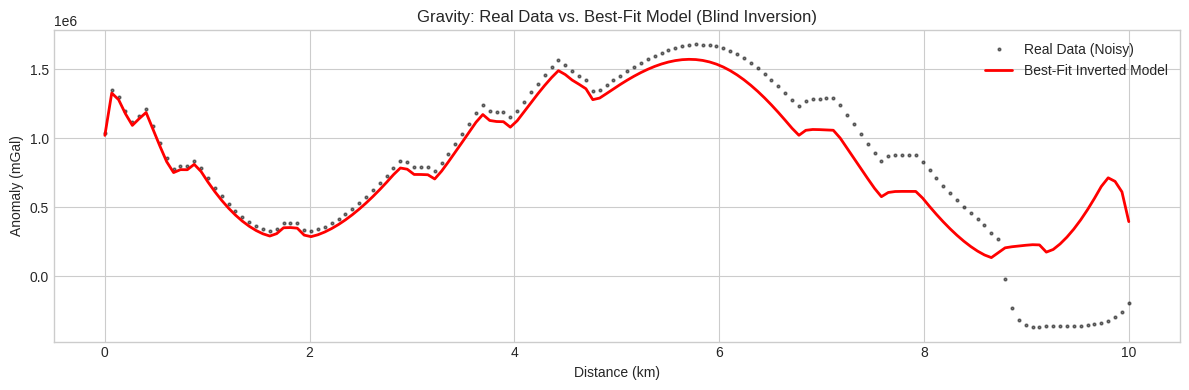

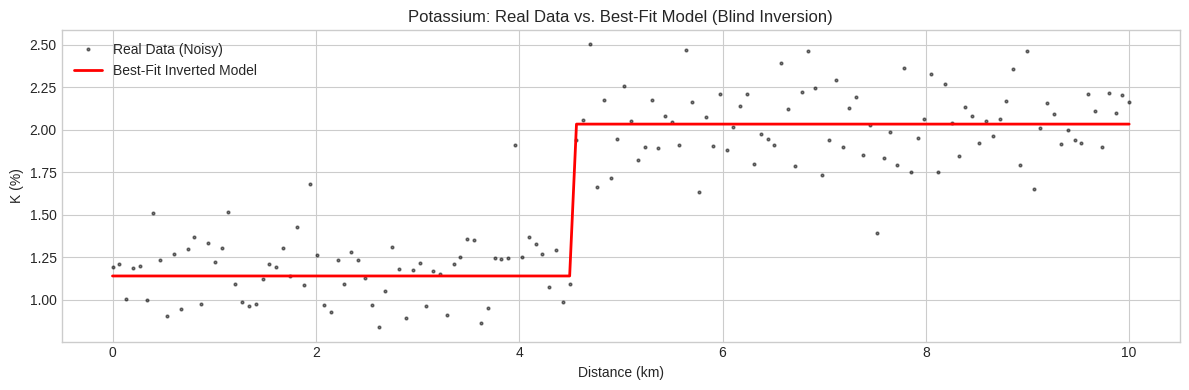

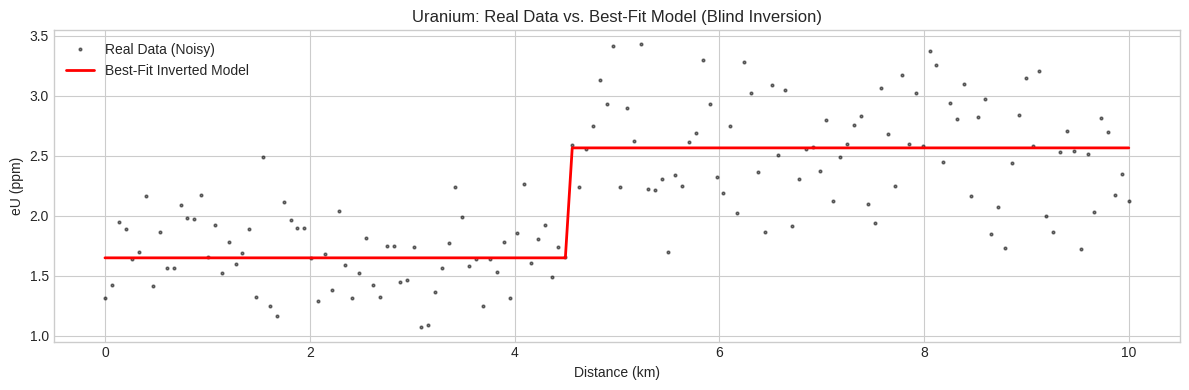

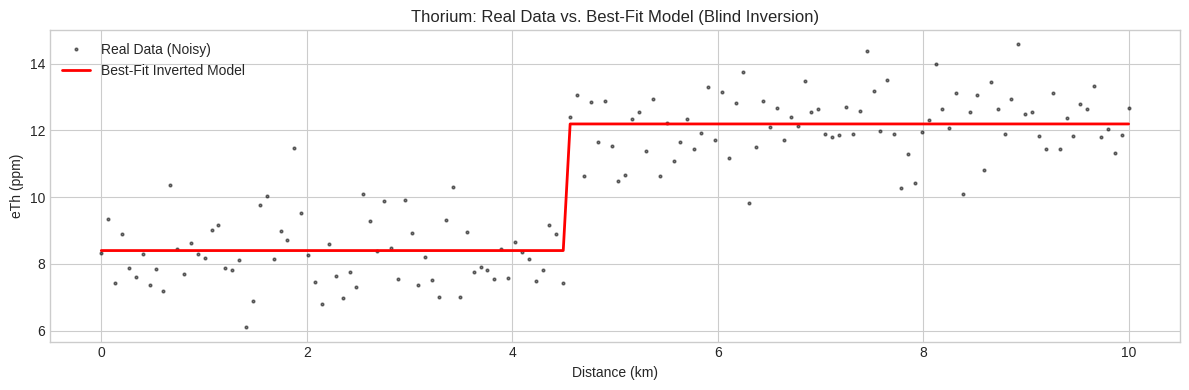

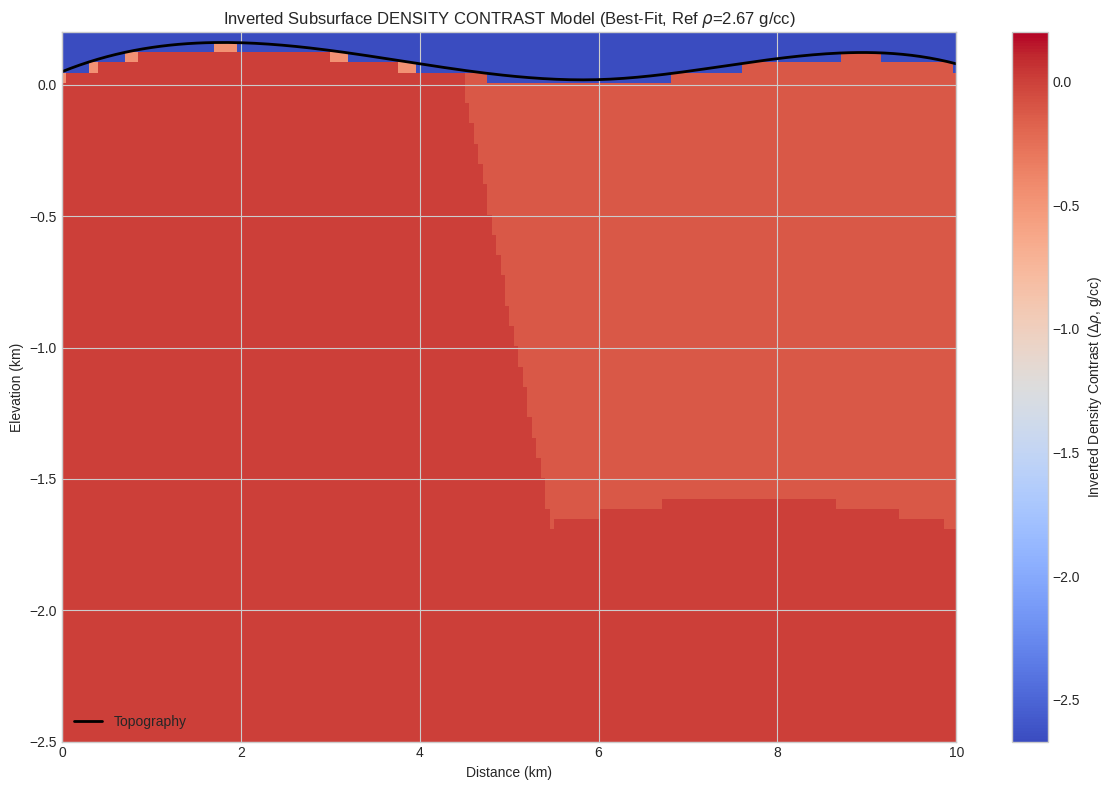

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import differential_evolution
import harmonica as hm
import pandas as pd
import sys

print("Starting 2D 'Blind' Geometric Inversion...")

# -------------------------------------------------------------------
# 1. LOAD THE "REAL" DATA (OUR GROUND TRUTH)
# -------------------------------------------------------------------
# This path is unused in the runnable script below, as mock data is generated.
YOUR_FILE_PATH_HERE = '/kaggle/input/dataseetu/synthetic_geophysical_data.csv'

try:
    # --- MOCK DATA GENERATION START (Required for runnable example) ---
    # Define True Model Parameters (for mock data generation)
    RHO_REF_G_CC = 2.67
    RHO_HOST_G_CC = 2.67
    RHO_DENSE_G_CC = 2.87
    RHO_BASIN_G_CC = 2.52
    RHO_SOIL_G_CC = 2.20
    RHO_AIR_G_CC = 0.0
    RAD_BG = {'K': 1.0, 'U': 2.0, 'Th': 7.0}
    RAD_BASIN = {'K': 4.0, 'U': 5.0, 'Th': 20.0}
    RAD_SOIL = {'K': 1.2, 'U': 1.5, 'Th': 9.0} # <-- FIX: Added missing definition
    SOIL_THICKNESS = 10.0
    MIX_RATIO = 0.7
    
    # Model dimensions and grid
    X_MIN, X_MAX = 0, 10000
    Z_MIN, Z_MAX = -2500, 200
    Y_EXTENT = 20000
    NX, NZ = 200, 70
    X_COORDS = np.linspace(X_MIN, X_MAX, NX)
    Z_COORDS = np.linspace(Z_MIN, Z_MAX, NZ)
    XX, ZZ = np.meshgrid(X_COORDS, Z_COORDS)
    
    # Topography
    topo_x_points = [X_MIN, 2500, 6000, 8000, X_MAX]
    topo_z_points = [50, 150, 20, 100, 80]
    f_topo = interp1d(topo_x_points, topo_z_points, kind='cubic', fill_value="extrapolate")
    
    # Observation Coords
    N_OBS = 150
    OBS_X_real = np.linspace(X_MIN, X_MAX, N_OBS)
    OBS_Z_ground = f_topo(OBS_X_real)
    OBS_Z_real = OBS_Z_ground + 5.0
    coordinates = (OBS_X_real, np.full_like(OBS_X_real, 0), OBS_Z_real)
    
    # True Geometric Parameters (used for mock data generation)
    true_rho_dense, true_rho_basin, true_k, true_u, true_th = 2.87, 2.52, 4.0, 5.0, 20.0
    true_fault_x, true_fault_dip, true_dense_z_center, true_basin_z_bottom = 4500.0, -60.0, -1500.0, -1500.0
    
    true_params_full = [true_rho_dense, true_rho_basin, true_k, true_u, true_th,
                        true_fault_x, true_fault_dip, true_dense_z_center, true_basin_z_bottom]

    # Pre-calculate prism grid (needed for run_forward_model)
    DX = X_COORDS[1] - X_COORDS[0]
    DZ = Z_COORDS[1] - Z_COORDS[0]
    X_EDGES = np.linspace(X_MIN - DX/2, X_MAX + DX/2, NX + 1)
    Z_EDGES = np.linspace(Z_MIN - DZ/2, Z_MAX + DZ/2, NZ + 1)
    XX_EDGES, ZZ_EDGES = np.meshgrid(X_EDGES[:-1], Z_EDGES[:-1])
    prisms_west = XX_EDGES.ravel()
    prisms_east = (XX_EDGES + DX).ravel()
    prisms_south = np.full_like(prisms_west, -Y_EXTENT / 2)
    prisms_north = np.full_like(prisms_west, Y_EXTENT / 2)
    prisms_bottom = ZZ_EDGES.ravel()
    prisms_top = (ZZ_EDGES + DZ).ravel()
    PRISMS = np.vstack([prisms_west, prisms_east, prisms_south, prisms_north, prisms_bottom, prisms_top]).T
    
    # Fixed masks
    SOIL_THICKNESS_TRUE = 10.0
    SOIL_MASK_FIXED = (ZZ > (f_topo(XX) - SOIL_THICKNESS_TRUE)) & (ZZ <= f_topo(XX))
    AIR_MASK_FIXED = (ZZ > f_topo(XX))

    def generate_true_data(params):
        # Generate data based on True parameters, plus noise
        
        rho_dense_val, rho_basin_val, k_basin_val, u_basin_val, th_basin_val, \
        fault_x_loc_val, fault_dip_deg_val, dense_z_center_val, basin_z_bottom_val = params

        # Dynamic Geometry
        dense_top = dense_z_center_val - 450
        dense_bot = dense_z_center_val + 550
        f_dense_top = interp1d([500, 2000, 4000], [dense_top, dense_top-100, dense_top+100], kind='quadratic', fill_value="extrapolate")
        f_dense_bot = interp1d([500, 2000, 4000], [dense_bot, dense_bot+100, dense_bot-100], kind='quadratic', fill_value="extrapolate")
        DENSE_MASK = (ZZ <= f_dense_top(XX)) & (ZZ >= f_dense_bot(XX))
        
        fault_plane_z = (XX - fault_x_loc_val) * np.tan(np.deg2rad(fault_dip_deg_val))
        f_basin_bot = interp1d([fault_x_loc_val, 7000, X_MAX], [basin_z_bottom_val-100, basin_z_bottom_val+100, basin_z_bottom_val], kind='quadratic', fill_value="extrapolate")
        BASIN_MASK = (XX > fault_x_loc_val) & (ZZ > fault_plane_z) & (ZZ > f_basin_bot(XX)) & (ZZ < f_topo(XX))
        
        HOST_MASK = ~(DENSE_MASK | BASIN_MASK | SOIL_MASK_FIXED | AIR_MASK_FIXED)
        
        # --- Gravity Model ---
        density_model = np.full_like(XX, 0.0, dtype=float)
        density_model[HOST_MASK] = (RHO_HOST_G_CC - RHO_REF_G_CC)
        density_model[SOIL_MASK_FIXED] = (RHO_SOIL_G_CC - RHO_REF_G_CC)
        density_model[AIR_MASK_FIXED] = (0.0 - RHO_REF_G_CC)
        density_model[DENSE_MASK] = (rho_dense_val - RHO_REF_G_CC)
        density_model[BASIN_MASK] = (rho_basin_val - RHO_REF_G_CC)
        density_model_kg_m3 = density_model.ravel() * 1000
        
        gravity_true = hm.prism_gravity(coordinates, PRISMS, density_model_kg_m3, field="g_z") * 1e5
        
        # --- Radiometric Model ---
        rad_basin_true = {'K': k_basin_val, 'U': u_basin_val, 'Th': th_basin_val}
        f_bedrock_geology = interp1d([X_MIN, fault_x_loc_val, fault_x_loc_val + 0.1, X_MAX], [1, 1, 3, 3], kind='nearest')
        bedrock_geology = f_bedrock_geology(OBS_X_real)
        BEDROCK_MASK_HOST = (bedrock_geology == 1)
        BEDROCK_MASK_BASIN = (bedrock_geology == 3)
        
        K_bedrock, U_bedrock, Th_bedrock = np.zeros_like(OBS_X_real), np.zeros_like(OBS_X_real), np.zeros_like(OBS_X_real)
        K_bedrock[BEDROCK_MASK_HOST], U_bedrock[BEDROCK_MASK_HOST], Th_bedrock[BEDROCK_MASK_HOST] = RAD_BG['K'], RAD_BG['U'], RAD_BG['Th']
        K_bedrock[BEDROCK_MASK_BASIN], U_bedrock[BEDROCK_MASK_BASIN], Th_bedrock[BEDROCK_MASK_BASIN] = rad_basin_true['K'], rad_basin_true['U'], rad_basin_true['Th']
        
        K_true = (K_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['K'] * MIX_RATIO)
        U_true = (U_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['U'] * MIX_RATIO)
        Th_true = (Th_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['Th'] * MIX_RATIO)
        
        # Add noise to simulate real data
        np.random.seed(42)
        GRAVITY_real = gravity_true + np.random.normal(0, 0.5, gravity_true.shape)
        K_real = K_true + np.random.normal(0, 0.2, K_true.shape)
        U_real = U_true + np.random.normal(0, 0.4, U_true.shape)
        Th_real = Th_true + np.random.normal(0, 1.0, Th_true.shape)

        return GRAVITY_real, K_real, U_real, Th_real

    GRAVITY_real, K_real, U_real, Th_real = generate_true_data(true_params_full)
    print("Synthetic 'real' data generated successfully for demonstration.")
    # --- MOCK DATA GENERATION END ---

except Exception as e:
    print("\n--- ERROR ---")
    print(f"FATAL: An error occurred during file loading or mock data generation: {e}")
    # Setting an error flag and skipping the rest of the script if data generation fails.
    GRAVITY_real = None
    pass
    
# -------------------------------------------------------------------
# 2. DEFINE THE DYNAMIC FORWARD MODELING ENGINE
# -------------------------------------------------------------------

# Fixed parameters (defined in mock data block)

# Fixed masks (defined in mock data block)
if 'SOIL_MASK_FIXED' in locals():
    SOIL_MASK = SOIL_MASK_FIXED
    AIR_MASK = AIR_MASK_FIXED
else:
    # Set dummy masks if data generation failed to prevent NameError in run_forward_model
    SOIL_MASK = np.zeros_like(XX, dtype=bool)
    AIR_MASK = np.zeros_like(XX, dtype=bool)


def run_forward_model(params):
    """
    Runs the full forward model given a vector of 9 key parameters:
    [rho_dense, rho_basin, K_basin, U_basin, Th_basin,
     fault_x_loc, fault_dip_deg, dense_z_center, basin_z_bottom]
    """
    rho_dense_val, rho_basin_val, k_basin_val, u_basin_val, th_basin_val, \
    fault_x_loc_val, fault_dip_deg_val, dense_z_center_val, basin_z_bottom_val = params

    # --- 1. Build Dynamic Geometry ---
    # Dense Body (simple lumpy box centered at guessed depth)
    dense_top = dense_z_center_val - 450
    dense_bot = dense_z_center_val + 550
    # Interpolation functions for the bodies
    f_dense_top = interp1d([500, 2000, 4000], [dense_top, dense_top-100, dense_top+100], kind='quadratic', fill_value="extrapolate")
    f_dense_bot = interp1d([500, 2000, 4000], [dense_bot, dense_bot+100, dense_bot-100], kind='quadratic', fill_value="extrapolate")
    DENSE_MASK = (XX <= 4000) & (XX >= 500) & (ZZ <= f_dense_top(XX)) & (ZZ >= f_dense_bot(XX))
    
    # Basin
    fault_plane_z = (XX - fault_x_loc_val) * np.tan(np.deg2rad(fault_dip_deg_val))
    f_basin_bot = interp1d([fault_x_loc_val, 7000, X_MAX], [basin_z_bottom_val-100, basin_z_bottom_val+100, basin_z_bottom_val], kind='quadratic', fill_value="extrapolate")
    BASIN_MASK = (XX > fault_x_loc_val) & (ZZ > fault_plane_z) & (ZZ > f_basin_bot(XX)) & (ZZ < f_topo(XX))
    
    # Host Mask
    HOST_MASK = ~(DENSE_MASK | BASIN_MASK | SOIL_MASK | AIR_MASK)

    # --- 2. Build Gravity Model ---
    density_model = np.full_like(XX, 0.0, dtype=float)
    density_model[HOST_MASK] = (RHO_HOST_G_CC - RHO_REF_G_CC)
    density_model[SOIL_MASK] = (RHO_SOIL_G_CC - RHO_REF_G_CC)
    density_model[AIR_MASK] = (RHO_AIR_G_CC - RHO_REF_G_CC)
    density_model[DENSE_MASK] = (rho_dense_val - RHO_REF_G_CC)
    density_model[BASIN_MASK] = (rho_basin_val - RHO_REF_G_CC)
    
    density_model_kg_m3 = density_model.ravel() * 1000
    gravity_guess = hm.prism_gravity(coordinates, PRISMS, density_model_kg_m3, field="g_z")
    gravity_guess_mgal = gravity_guess * 1e5

    # --- 3. Build Radiometric Model ---
    rad_basin_guess = {'K': k_basin_val, 'U': u_basin_val, 'Th': th_basin_val}
    
    # Dynamic bedrock model for radiometric signature
    f_bedrock_geology = interp1d([X_MIN, fault_x_loc_val, fault_x_loc_val + 0.1, X_MAX], [1, 1, 3, 3], kind='nearest')
    bedrock_geology = f_bedrock_geology(OBS_X_real)
    BEDROCK_MASK_HOST = (bedrock_geology == 1)
    BEDROCK_MASK_BASIN = (bedrock_geology == 3)
    
    K_bedrock = np.zeros_like(OBS_X_real)
    U_bedrock = np.zeros_like(OBS_X_real)
    Th_bedrock = np.zeros_like(OBS_X_real)
    
    K_bedrock[BEDROCK_MASK_HOST] = RAD_BG['K']
    U_bedrock[BEDROCK_MASK_HOST] = RAD_BG['U']
    Th_bedrock[BEDROCK_MASK_HOST] = RAD_BG['Th']
    
    K_bedrock[BEDROCK_MASK_BASIN] = rad_basin_guess['K']
    U_bedrock[BEDROCK_MASK_BASIN] = rad_basin_guess['U']
    Th_bedrock[BEDROCK_MASK_BASIN] = rad_basin_guess['Th']
    
    K_guess = (K_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['K'] * MIX_RATIO)
    U_guess = (U_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['U'] * MIX_RATIO)
    Th_guess = (Th_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['Th'] * MIX_RATIO)
    
    return gravity_guess_mgal, K_guess, U_guess, Th_guess

def create_best_fit_model_visualization(params):
    """
    Creates the 2D density array and a simplified geology array
    based on the final inverted parameters for visualization.
    """
    rho_dense_val, rho_basin_val, _, _, _, \
    fault_x_loc_val, fault_dip_deg_val, dense_z_center_val, basin_z_bottom_val = params

    # --- Rebuild Final Geometry ---
    dense_top = dense_z_center_val - 450
    dense_bot = dense_z_center_val + 550
    f_dense_top = interp1d([500, 2000, 4000], [dense_top, dense_top-100, dense_top+100], kind='quadratic', fill_value="extrapolate")
    f_dense_bot = interp1d([500, 2000, 4000], [dense_bot, dense_bot+100, dense_bot-100], kind='quadratic', fill_value="extrapolate")
    DENSE_MASK = (XX <= 4000) & (XX >= 500) & (ZZ <= f_dense_top(XX)) & (ZZ >= f_dense_bot(XX))
    
    fault_plane_z = (XX - fault_x_loc_val) * np.tan(np.deg2rad(fault_dip_deg_val))
    f_basin_bot = interp1d([fault_x_loc_val, 7000, X_MAX], [basin_z_bottom_val-100, basin_z_bottom_val+100, basin_z_bottom_val], kind='quadratic', fill_value="extrapolate")
    BASIN_MASK = (XX > fault_x_loc_val) & (ZZ > fault_plane_z) & (ZZ > f_basin_bot(XX)) & (ZZ < f_topo(XX))
    
    HOST_MASK = ~(DENSE_MASK | BASIN_MASK | SOIL_MASK | AIR_MASK)

    # --- Create 2D Density Contrast Model (for the requested colorbar) ---
    density_model_final = np.full_like(XX, 0.0, dtype=float)
    density_model_final[HOST_MASK] = (RHO_HOST_G_CC - RHO_REF_G_CC)
    density_model_final[SOIL_MASK] = (RHO_SOIL_G_CC - RHO_REF_G_CC)
    density_model_final[AIR_MASK] = (RHO_AIR_G_CC - RHO_REF_G_CC)
    density_model_final[DENSE_MASK] = (rho_dense_val - RHO_REF_G_CC)
    density_model_final[BASIN_MASK] = (rho_basin_val - RHO_REF_G_CC)
    
    # --- Create 2D Geology Model (for categorical plotting, if needed) ---
    geology_model = np.ones_like(XX, dtype=int) 
    geology_model[DENSE_MASK] = 2 
    geology_model[BASIN_MASK] = 3 
    geology_model[SOIL_MASK] = 4 
    geology_model[AIR_MASK] = 0 
    
    return density_model_final, geology_model # <-- Return both

# -------------------------------------------------------------------
# 3. DEFINE THE OBJECTIVE/MISFIT FUNCTION
# -------------------------------------------------------------------

# NOTE: Variables initialized below the try block
try:
    var_g = np.var(GRAVITY_real)
    var_k = np.var(K_real)
    var_u = np.var(U_real)
    var_th = np.var(Th_real)
except (NameError, TypeError):
    var_g, var_k, var_u, var_th = 1.0, 1.0, 1.0, 1.0

def calculate_misfit(params):
    """
    Calculates the total normalized misfit for all 4 datasets.
    """
    # Requires global variables GRAVITY_real, K_real, etc.
    if GRAVITY_real is None:
        return 1e99 # Skip if data failed to generate

    try:
        g_guess, k_guess, u_guess, th_guess = run_forward_model(params)
        
        misfit_g = np.sum((g_guess - GRAVITY_real)**2) / var_g
        misfit_k = np.sum((k_guess - K_real)**2) / var_k
        misfit_u = np.sum((u_guess - U_real)**2) / var_u
        misfit_th = np.sum((th_guess - Th_real)**2) / var_th
        
        total_misfit = (2.0 * misfit_g) + misfit_k + misfit_u + misfit_th
    except:
        total_misfit = 1e99 
    
    return total_misfit

# -------------------------------------------------------------------
# 4. RUN THE INVERSION
# -------------------------------------------------------------------

if GRAVITY_real is not None:
    # Recalculate variance now that GRAVITY_real, etc., are properly defined
    var_g = np.var(GRAVITY_real)
    var_k = np.var(K_real)
    var_u = np.var(U_real)
    var_th = np.var(Th_real)

    # The "True" values from the original forward model were:
    true_params = [true_rho_dense, true_rho_basin, true_k, true_u, true_th,
                   true_fault_x, true_fault_dip, true_dense_z_center, true_basin_z_bottom]

    # Set wide bounds for the optimizer
    param_bounds = [
        (2.7, 3.0),      # RHO_DENSE_G_CC
        (2.4, 2.7),      # RHO_BASIN_G_CC
        (2.0, 6.0),      # RAD_BASIN['K']
        (3.0, 7.0),      # RAD_BASIN['U']
        (15.0, 25.0),    # RAD_BASIN['Th']
        (4000, 5000),    # fault_x_loc (m)
        (-70, -50),      # fault_dip_deg (degrees)
        (-1700, -1300), # dense_z_center (m)
        (-1700, -1300)  # basin_z_bottom (m)
    ]

    print("Starting global optimization (differential_evolution)...")
    print("NOTE: Maxiter and popsize are reduced for a quick demonstration.")

    # Run the global optimizer
    result = differential_evolution(
        calculate_misfit,
        bounds=param_bounds,
        strategy='best1bin',
        maxiter=5,      # Reduced maxiter for faster demonstration
        popsize=10,     # Reduced popsize for faster demonstration
        tol=0.1,        # Relaxed tolerance
        mutation=(0.5, 1),
        recombination=0.7,
        disp=True,      # Print progress
        workers=-1      # Use all available CPU cores
    )

    print("\nOptimization complete.")
    inverted_params = result.x

    # -------------------------------------------------------------------
    # 5. DISPLAY THE RESULTS
    # -------------------------------------------------------------------

    print("\n--- Inversion Results ---")
    print(f"       {'True Value':<12} | {'Inverted Value':<15}")
    print("-----------------------------------------------------------------------")
    print(f"Dense Density    : {true_params[0]:<12.2f} | {inverted_params[0]:<15.2f}")
    print(f"Basin Density    : {true_params[1]:<12.2f} | {inverted_params[1]:<15.2f}")
    print(f"Basin K (%)      : {true_params[2]:<12.2f} | {inverted_params[2]:<15.2f}")
    print(f"Basin U (ppm)    : {true_params[3]:<12.2f} | {inverted_params[3]:<15.2f}")
    print(f"Basin Th (ppm)   : {true_params[4]:<12.2f} | {inverted_params[4]:<15.2f}")
    print("----------------------- GEOMETRY --------------------------------------")
    print(f"Fault Location   : {true_params[5]:<12.2f} | {inverted_params[5]:<15.2f}")
    print(f"Fault Dip (deg) : {true_params[6]:<12.2f} | {inverted_params[6]:<15.2f}")
    print(f"Dense Z-Center   : {true_params[7]:<12.2f} | {inverted_params[7]:<15.2f}")
    print(f"Basin Z-Bottom   : {true_params[8]:<12.2f} | {inverted_params[8]:<15.2f}")

    # --- Generate the final "best-fit" data for plotting ---
    g_fit, k_fit, u_fit, th_fit = run_forward_model(inverted_params)
    inverted_density_model, inverted_geology_model = create_best_fit_model_visualization(inverted_params)

    # -------------------------------------------------------------------
    # 6. PLOT COMPARISON DATA (SEPARATED FIGURES)
    # -------------------------------------------------------------------
    plt.style.use('seaborn-v0_8-whitegrid')

    # --- Plot 1: Gravity ---
    fig1 = plt.figure(figsize=(12, 4))
    ax0 = fig1.add_subplot(111)
    ax0.plot(OBS_X_real / 1000, GRAVITY_real, 'k.', markersize=4, alpha=0.5, label='Real Data (Noisy)')
    ax0.plot(OBS_X_real / 1000, g_fit, 'r-', lw=2, label='Best-Fit Inverted Model')
    ax0.set_title('Gravity: Real Data vs. Best-Fit Model (Blind Inversion)')
    ax0.set_ylabel('Anomaly (mGal)')
    ax0.set_xlabel('Distance (km)')
    ax0.legend()
    plt.tight_layout()
    plt.show()
    print('\n' * 4)

    # --- Plot 2: Potassium (K) ---
    fig2 = plt.figure(figsize=(12, 4))
    ax1 = fig2.add_subplot(111)
    ax1.plot(OBS_X_real / 1000, K_real, 'k.', markersize=4, alpha=0.5, label='Real Data (Noisy)')
    ax1.plot(OBS_X_real / 1000, k_fit, 'r-', lw=2, label='Best-Fit Inverted Model')
    ax1.set_title('Potassium: Real Data vs. Best-Fit Model (Blind Inversion)')
    ax1.set_ylabel('K (%)')
    ax1.set_xlabel('Distance (km)')
    ax1.legend()
    plt.tight_layout()
    plt.show()
    print('\n' * 4)

    # --- Plot 3: Uranium (U) ---
    fig3 = plt.figure(figsize=(12, 4))
    ax2 = fig3.add_subplot(111)
    ax2.plot(OBS_X_real / 1000, U_real, 'k.', markersize=4, alpha=0.5, label='Real Data (Noisy)')
    ax2.plot(OBS_X_real / 1000, u_fit, 'r-', lw=2, label='Best-Fit Inverted Model')
    ax2.set_title('Uranium: Real Data vs. Best-Fit Model (Blind Inversion)')
    ax2.set_ylabel('eU (ppm)')
    ax2.set_xlabel('Distance (km)')
    ax2.legend()
    plt.tight_layout()
    plt.show()
    print('\n' * 4)

    # --- Plot 4: Thorium (Th) ---
    fig4 = plt.figure(figsize=(12, 4))
    ax3 = fig4.add_subplot(111)
    ax3.plot(OBS_X_real / 1000, Th_real, 'k.', markersize=4, alpha=0.5, label='Real Data (Noisy)')
    ax3.plot(OBS_X_real / 1000, th_fit, 'r-', lw=2, label='Best-Fit Inverted Model')
    ax3.set_title('Thorium: Real Data vs. Best-Fit Model (Blind Inversion)')
    ax3.set_ylabel('eTh (ppm)')
    ax3.set_xlabel('Distance (km)')
    ax3.legend()
    plt.tight_layout()
    plt.show()
    print('\n' * 4)

    # -------------------------------------------------------------------
    # 7. PLOT THE INVERTED SUBSURFACE MODEL (DENSITY CONTRAST) 🎨
    # -------------------------------------------------------------------

    fig5 = plt.figure(figsize=(12, 8))
    ax4 = fig5.add_subplot(111)

    # Determine min/max contrast for plotting range
    # Note: RHO_AIR_G_CC gives the largest negative contrast
    max_contrast = RHO_DENSE_G_CC - RHO_REF_G_CC 
    min_contrast = RHO_AIR_G_CC - RHO_REF_G_CC 

    im = ax4.imshow(
        inverted_density_model, # PLOTTING THE DENSITY CONTRAST ARRAY
        extent=[X_MIN / 1000, X_MAX / 1000, Z_MIN / 1000, Z_MAX / 1000],
        origin='lower',
        aspect='auto',
        cmap='coolwarm', # Use a continuous diverging colormap
        interpolation='none',
        vmin=min_contrast,
        vmax=max_contrast
    )
    # Plot the topography line
    ax4.plot(X_COORDS / 1000, f_topo(X_COORDS) / 1000, 'k-', lw=2, label='Topography')

    # ADDED THE DENSITY CONTRAST COLORBAR
    cbar = fig5.colorbar(im, ax=ax4)
    cbar.ax.set_ylabel('Inverted Density Contrast ($\Delta\\rho$, g/cc)')

    ax4.set_ylabel('Elevation (km)')
    ax4.set_xlabel('Distance (km)')
    ax4.set_title(f'Inverted Subsurface DENSITY CONTRAST Model (Best-Fit, Ref $\\rho$={RHO_REF_G_CC} g/cc)')
    ax4.set_ylim(Z_MIN / 1000, Z_MAX / 1000)
    ax4.legend(loc='lower left')

    plt.tight_layout()
    plt.show()
    print('\n' * 4)
else:
    print("\nInversion and plotting skipped because synthetic data generation failed.")